# Esercitazione 4: classificazione dello stato di un modello di Ising 2D e predizione del suo stato di magnetizzazione media con modelli di Decision Trees e Random Forests

**Task:** implementare algoritmi di classificazione e regressione basati su alberi e foreste di alberi di decisioni binarie con bagging per lo studio di un sistema di ising in 2D con condizioni periodiche al contorno

In [1]:
!rm -rf ising_conf.dat.gz
!rm -rf ising_conf.dat
!rm -rf ising_label.dat.gz
!rm -rf ising_label.dat
!rm -rf JetSubStruct.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
!wget http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
!gunzip ising_conf.dat.gz
!gunzip ising_label.dat.gz

--2025-03-03 14:27:17--  http://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.18.46, 137.138.124.182, 188.185.5.88, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz [following]
--2025-03-03 14:27:18--  https://giagu.web.cern.ch/giagu/CERN/ising_conf.dat.gz
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2953855 (2.8M) [application/x-gzip]
Saving to: ‘ising_conf.dat.gz’

ising_conf.dat.gz   100%[===================>]   2.82M  2.32MB/s    in 1.2s    

2025-03-03 14:27:20 (2.32 MB/s) - ‘ising_conf.dat.gz’ saved [2953855/2953855]

--2025-03-03 14:27:20--  http://giagu.web.cern.ch/giagu/CERN/ising_label.dat.gz
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.5.88, 137.138.124.182,

### Informazioni di base sul Modello di Ising 2D ###

dettagli (definizione teorica e simulazione) nella [nota](https://vixra.org/pdf/1710.0021v2.pdf).

È costituito da una serie di spin (che possono assumere solo i valori -1 (down) e +1 (up)) interagenti tra loro, posti ai vertici di un reticolo quadrato bidimensionale. La dinamica del sistema (in assenza di campo magnetico esterno) è descritta dall'Hamiltoniana:

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

in cui gli indici del reticolo $i,j$ sono associati ai primi vicini di un reticolo 2D quadrato di lato $L$, e $J$ è un parametro di scala arbitrario che definisce la scala dell'energia di interazione tra gli spin $S_i$.
Si utilizzano condizioni periodiche al contorno sul reticolo.

Si può dimostrare che questo sistema presenta una transizione di fase nel limite termodinamico da un sistema ordinato con tutti gli spin allineati (ferromagnete ordinato) a temperatura zero, a una fase disordinata con spin competamente random, ad alta temperatura. La temperatura critica a cui avviene la transizione è data da $T_c/J=1/\log(1+\sqrt{2})\approx 2.26$.


**Dataset:**

Vengono fornite 25k configurazioni con $T/J$ uniforme in $[0,5]$ di un modello ising 2D su un reticolo $28\times 28$ simulato tramite un semplice Monte Carlo tipo Metropolis.

Il campione è disponibile in due file:

* configurazioni: *ising_conf.dat*
* label: *ising_label.dat*

NOTA BENE: le configurazioni sono salvate in file testuali, che letti con numpy (*np.loadtxt*) forniscono tensori di shape *(25000x28,28)* che vanno reshaped nel formato *(25000,28x28)* e *(25000,28,28)* per essere utilizzati con scikit-learn in modo efficiente.

**Parte 1:**

Loading, analisi e pre-processamento del dataset:

1.   leggere le configurazioni e salvarle in due tensori numpy *data(25000,784)* e *data_2d(25000,28,28)*, usando il metodo *np.loadtxt* di numpy. Idem per le temperature: *temp(25000,1)*
2.   poiché è noto che vicino alla temepratura critica $T_c$, la lunghezza delle correlazioni ferromagnetiche diverge, rendendo difficile identificare la fase, dividere il campione in tre sotto-campioni corrispondenti alle classi:

* ordinato: $T<2.0$
* critico: $2.0\leq T\leq 2.5$
* disordinato: $T>2.5$

     costruendo un nuovo tensore numpy di label *(0,1,2)* da associare ad ogni configurazione in *data/data_2d*.
    
3.   visualizzare un evento per ciascuna classe usando matplotlib: *plt.imshow*  (nota: usare il tensore in formato (28,28) *data_2d*)


In [2]:
import numpy as np
data = np.loadtxt('ising_conf.dat')
temp = np.loadtxt('ising_label.dat')

In [3]:
data = data.reshape(25000, 784)
data_2d = data.reshape(25000,28,28)
temp = temp.reshape(25000,1)

print(f'''
data shape: {data.shape}
data_2d shape: {data_2d.shape}
temp shape: {temp.shape}
''')


data shape: (25000, 784)
data_2d shape: (25000, 28, 28)
temp shape: (25000, 1)



In [4]:
# siccome temp ha due colonne, questi array hanno due dimensioni, mi serve solo la prima
ord = np.where(temp < 2.0)
cr = np.where((temp <= 2.5) & (temp >= 2.0))
dis = np.where(temp > 2.5)

data_ord = data[ord[0]]
data_cr = data[cr[0]]
data_dis = data[dis[0]]
data2d_ord = data_2d[ord[0]]
data2d_cr = data_2d[cr[0]]
data2d_dis = data_2d[dis[0]]

label = np.zeros(25000)

for k,item in enumerate(temp):
  if item < 2.0:
    label[k] = 0
  if item > 2.5:
    label[k] = 2
  if item <= 2.5 and item >= 2.0:
    label[k] = 1

print(f'''
conf ord: {data_ord.shape[0]}
conf cr : {data_cr.shape[0]}
conf dis: {data_dis.shape[0]}
''')


conf ord: 9953
conf cr : 2563
conf dis: 12484



<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

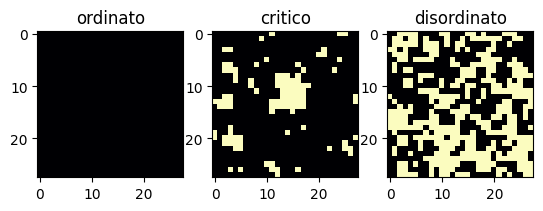

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.imshow(data2d_ord[3], cmap='magma')
plt.title('ordinato')
plt.subplot(1,3,2)
plt.imshow(data2d_cr[0], cmap='magma')
plt.title('critico')
plt.subplot(1,3,3)
plt.imshow(data2d_dis[0], cmap='magma')
plt.title('disordinato')
plt.tight_layout

**Parte 2**:

Implementazione di due classificatori basati su un **albero di decisione binaria, una random forest (basata su bagging)**, addestrati alla task di identificare la classe (0,1,2) delle configurazioni (ordinata, critica, disordinata).

1.   dividere campione e label in tre sotto-campioni: **training, validation e test set** (*60-20-20 %*) usando sklearn:

`from sklearn.model_selection import train_test_split`

2.   implementare e **addestrare sul campione di training** i due classificator:

```
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
```

3.   usando come metrica l'accuracy, **ottmizzare gli iperparametri** dei modelli (NOTA: valutare l'accuracy sia sul **training set** che sul **validation set** e usare quest'ultima come misura non distorta delle prestazioni in generalizzazione del modello):

*   DecisionTreeClassifier: *max_depth*, 10 valori in [1,10]
*   RandomForestClassifier: *n_estimators*, 10 valori in [2,100], e *min_samples_split*, testare 2 valori per il parametro =2 e =10000

4.  insieme all'accuracy stimata sul test calcolare anche l'accuracy sul campione Out-Of-Bag (OOB: disponibile solo per le RandomForest, vedi la nota successiva per una spiegazione)
5.   graficare accuracy e stima OOB sul training e test set in funzione del valore del parametro ottimizzato
6.   confrontare in termini di **accuracy media** e **matrice di confusione** calcolate sul *campione di test* i risultati ottenuti con i due modelli ottimizzati

**NOTA: RandomForest in scikit-learn**

**Iperparametri**

Usiamo l'implementazione in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) che ha due iperparamteri principali che possono modificare anche sensibimente le prestazioni del modello e il livelo di overfit/underfit: il numero di alberi nella foresta e la complessità di ciascun albero: il primo è controllato dal parametro `n_estimators`, mentre la complesiità è controllata da vari parametri `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc, in parte correlati tra loro. Nell'esempio in esame per semplicità useremo solo `min_samples_split` (governa il numero di campioni necessari per procedere ad uno split di un nodo: più alto è il numero minore sarà la segmentazione e le diramazioni dell'albero.
Per il semplice DecisionTreeClassifier useremo *max_depth*: che controlla la massima profondità dell'albero.

**Stima OOB (Out Of Bag)**

È un metodo molto utile per ottimizzare gli iperparametri quando si usano metodi di bagging: consiste nel verificare quanto bene funziona il classificatore su quegli eventi del training set che non sono stati usati perchè non campionati nella tecnica di boostrap. Gioca un ruolo simile alla k-fold cross-validation. È disponibile come metodo di RandomForestClassifier: *.oob_score_*

In [6]:
from sklearn.model_selection import train_test_split

rnd_ini = 123456
np.random.seed(rnd_ini)
train_to_rest_ratio = 0.60
train_to_test_ratio = 0.50

x_train, x_rest, y_train, y_rest = train_test_split(data, label, train_size = train_to_rest_ratio, shuffle=True, random_state=rnd_ini)
x_vali, x_test, y_vali, y_test = train_test_split(x_rest, y_rest, train_size = train_to_test_ratio, shuffle=True, random_state=rnd_ini)


  max_depth = 1
  train accuracy     : 0.49907
  validation accuracy: 0.49220 

  max_depth = 3
  train accuracy     : 0.73620
  validation accuracy: 0.73080 

  max_depth = 5
  train accuracy     : 0.81980
  validation accuracy: 0.81380 

  max_depth = 7
  train accuracy     : 0.85140
  validation accuracy: 0.83460 

  max_depth = 9
  train accuracy     : 0.89373
  validation accuracy: 0.82880 

  max_depth = 11
  train accuracy     : 0.94100
  validation accuracy: 0.81680 

  max_depth = 13
  train accuracy     : 0.95760
  validation accuracy: 0.83060 

  max_depth = 15
  train accuracy     : 0.96893
  validation accuracy: 0.82620 

  max_depth = 17
  train accuracy     : 0.97547
  validation accuracy: 0.83320 

  max_depth = 20
  train accuracy     : 0.98220
  validation accuracy: 0.82880 

best accuracy: 0.8346 per max_depth = 7

Test accuracy:  0.832
Confusion Matrix:
[[0.9491353  0.00406918 0.04679552]
 [0.55130785 0.01408451 0.43460765]
 [0.09184076 0.00670083 0.90145842]]


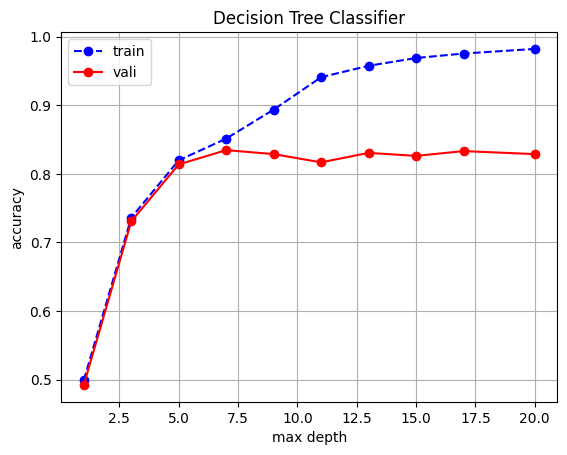

In [10]:
from sklearn.tree import DecisionTreeClassifier
depth = np.linspace(1,20,10, dtype='int')
train_accuracy = []
val_accuracy = []

for k, item in enumerate(depth):
  model = DecisionTreeClassifier(max_depth = item)
  model.fit(x_train, y_train)
  train_accuracy.append( model.score(x_train, y_train))
  val_accuracy.append( model.score(x_vali, y_vali))
  print(f'''
  max_depth = {item}
  train accuracy     : {train_accuracy[k]:.5f}
  validation accuracy: {val_accuracy[k]:.5f} ''')

plt.plot(depth, train_accuracy, marker='o', linestyle='--', c='b', label='train')
plt.plot(depth, val_accuracy, marker='o', linestyle='-', c='r', label='vali')
plt.grid()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend()
plt.title('Decision Tree Classifier')

val_accuracy = np.array(val_accuracy)
best_acc = val_accuracy.max()
index = np.where(val_accuracy == best_acc)[0][0]

print(f'''
best accuracy: {best_acc:.4f} per max_depth = {depth[index]}
''')

DT_clf = DecisionTreeClassifier(max_depth= depth[index])
DT_clf.fit(x_train, y_train)
test_acc = DT_clf.score(x_test, y_test)
print('Test accuracy: ', test_acc)


test_pred = DT_clf.predict(x_test)
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(y_test, test_pred, normalize='true')
print("Confusion Matrix:")
print(c_mat)


**Commento alle accuracy vs max_depth**

- per profondità basse è evidente l'underfitting del modello che non riesce a catturare le relazioni nei dati;
- per profondità intermedie il modello comincia ad apprendere e a generalizzare;
- per profondità elevate il modello sta overfittando, infatti l'accuracy sul train continua ad aumentare mentre quella sul vali si stabilizza;


  n_estimators = 2
  train accuracy     : 0.93813
  validation accuracy: 0.85840 

  n_estimators = 10
  train accuracy     : 0.98353
  validation accuracy: 0.91880 

  n_estimators = 25
  train accuracy     : 0.98693
  validation accuracy: 0.91740 

  n_estimators = 33
  train accuracy     : 0.98687
  validation accuracy: 0.91840 

  n_estimators = 45
  train accuracy     : 0.98980
  validation accuracy: 0.91860 

  n_estimators = 56
  train accuracy     : 0.99033
  validation accuracy: 0.91900 

  n_estimators = 68
  train accuracy     : 0.99000
  validation accuracy: 0.91720 

  n_estimators = 77
  train accuracy     : 0.99080
  validation accuracy: 0.91800 

  n_estimators = 89
  train accuracy     : 0.99067
  validation accuracy: 0.91840 

  n_estimators = 96
  train accuracy     : 0.99113
  validation accuracy: 0.91800 

best accuracy: 0.9190 per max_depth = 11



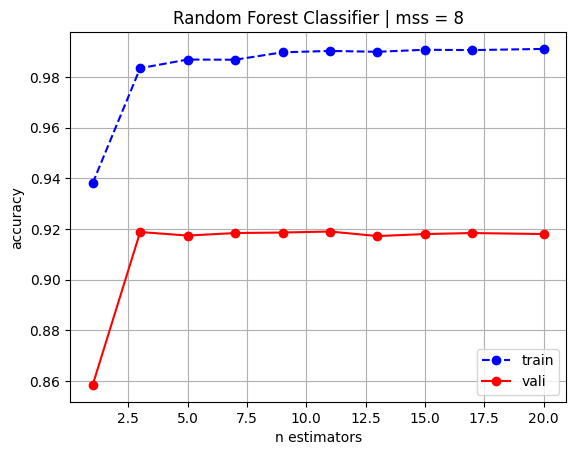

In [11]:
from sklearn.ensemble import RandomForestClassifier

estimators = [2, 10, 25, 33, 45, 56, 68, 77, 89, 96]
mss = 8  # min_samples_split

train_accuracy = []
val_accuracy = []

for k, item in enumerate(estimators):
  model = RandomForestClassifier(n_estimators = item, min_samples_split = mss)
  model.fit(x_train, y_train)
  train_accuracy.append( model.score(x_train, y_train))
  val_accuracy.append( model.score(x_vali, y_vali))
  print(f'''
  n_estimators = {item}
  train accuracy     : {train_accuracy[k]:.5f}
  validation accuracy: {val_accuracy[k]:.5f} ''')

plt.plot(depth, train_accuracy, marker='o', linestyle='--', c='b', label='train')
plt.plot(depth, val_accuracy, marker='o', linestyle='-', c='r', label='vali')
plt.grid()
plt.xlabel('n estimators')
plt.ylabel('accuracy')
plt.legend()
plt.title(f'Random Forest Classifier | mss = {mss}')

val_accuracy = np.array(val_accuracy)
best_acc = val_accuracy.max()
index = np.where(val_accuracy == best_acc)[0][0]

print(f'''
best accuracy: {best_acc:.4f} per max_depth = {depth[index]}
''')

**Commento all'accuracy vs n_estimators**

Il modello ha overfittato, e questo si può dire perché:
- mss = 2 permette al modello di arrivare ad avere foglie quasi pure;
- le due accuracy sono elevate e molto separate;

**Altro codice, con OOB**

In [12]:
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
#disabilitiamo messaggi di warning
warnings.filterwarnings("ignore")

#Valore del numero di alberi
n_estimator_range=np.linspace(2,100,10, dtype='int')
leaf_size_range=[2,10000]

m=len(n_estimator_range)
n=len(leaf_size_range)

# allocate arrays for various quantities
RFC_OOB_accuracy=np.zeros((n,m))
RFC_train_accuracy=np.zeros((n,m))
RFC_vali_accuracy=np.zeros((n,m))
run_time=np.zeros((n,m))

print_flag=True

for i, leaf_size in enumerate(leaf_size_range):
    # Define Random Forest Classifier
    myRF_clf = RandomForestClassifier(
        n_estimators=n_estimator_range[0],
        max_depth=None,
        min_samples_split=leaf_size,  # minimum number of sample per leaf
        oob_score=True,
        random_state=0,
        warm_start=True  # When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest.
    )
    for j, n_estimator in enumerate(n_estimator_range):

        print('n_estimators: %i, leaf_size: %i'%(n_estimator,leaf_size))

        start_time = time.time()
        myRF_clf.set_params(n_estimators=n_estimator)
        myRF_clf.fit(x_train, y_train)
        run_time[i,j] = time.time() - start_time

    # check accuracy
        RFC_train_accuracy[i,j]=myRF_clf.score(x_train,y_train)
        RFC_OOB_accuracy[i,j]=myRF_clf.oob_score_
        RFC_vali_accuracy[i,j]=myRF_clf.score(x_vali,y_vali)
        if print_flag:
            result = (run_time[i,j], RFC_train_accuracy[i,j], RFC_OOB_accuracy[i,j], RFC_vali_accuracy[i,j])
            print('{0:<15}{1:<15}{2:<15}{3:<15}'.format("time (s)","train score", "OOB estimate","validation score"))
            print('{0:<15.4f}{1:<15.4f}{2:<15.4f}{3:<15.4f}'.format(*result))

n_estimators: 2, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.2755         0.9178         0.6552         0.7924         
n_estimators: 12, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.9836         0.9972         0.8807         0.9156         
n_estimators: 23, leaf_size: 2
time (s)       train score    OOB estimate   validation score
0.9317         0.9995         0.9082         0.9150         
n_estimators: 34, leaf_size: 2
time (s)       train score    OOB estimate   validation score
1.1010         0.9996         0.9125         0.9152         
n_estimators: 45, leaf_size: 2
time (s)       train score    OOB estimate   validation score
2.3980         0.9999         0.9132         0.9152         
n_estimators: 56, leaf_size: 2
time (s)       train score    OOB estimate   validation score
1.7131         1.0000         0.9148         0.9164         
n_estimators: 67, leaf_size: 2
time (s)       train score    OOB estimate   v

In [13]:
best_acc = np.max(RFC_vali_accuracy)
index_best = np.unravel_index(RFC_vali_accuracy.argmax(), RFC_vali_accuracy.shape)
print('Best accuracy: ', best_acc, ' per n_estimators=', n_estimator_range[index_best[1]],
      ', min_samples_split=', leaf_size_range[index_best[0]])


myRF_clf = RandomForestClassifier(
        n_estimators=n_estimator_range[index_best[1]],
        max_depth=None,
        min_samples_split=leaf_size_range[index_best[0]],
        oob_score=True,
        random_state=0,
        warm_start=True
)

myRF_clf.fit(x_train, y_train)
test_acc = myRF_clf.score(x_test, y_test)
print('Test accuracy: ', test_acc)


test_pred = myRF_clf.predict(x_test)
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(y_test, test_pred, normalize='true')
print("Confusion Matrix:")
print(c_mat)

Best accuracy:  0.918  per n_estimators= 100 , min_samples_split= 2
Test accuracy:  0.9192
Confusion Matrix:
[[9.99491353e-01 0.00000000e+00 5.08646999e-04]
 [4.56740443e-01 1.89134809e-01 3.54124748e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


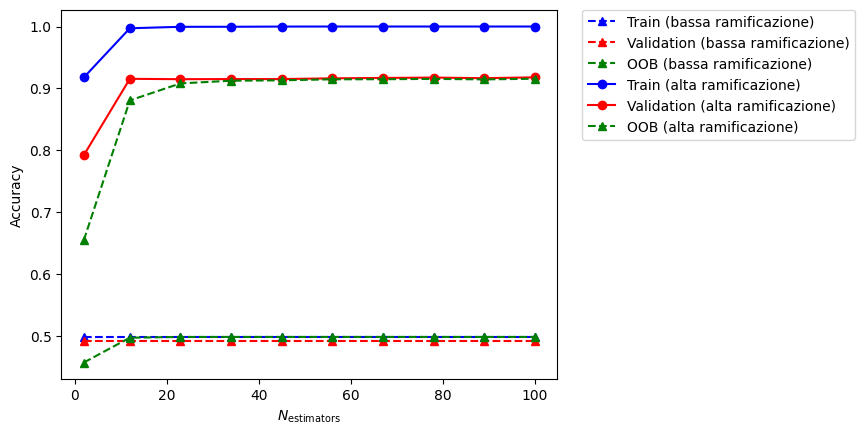

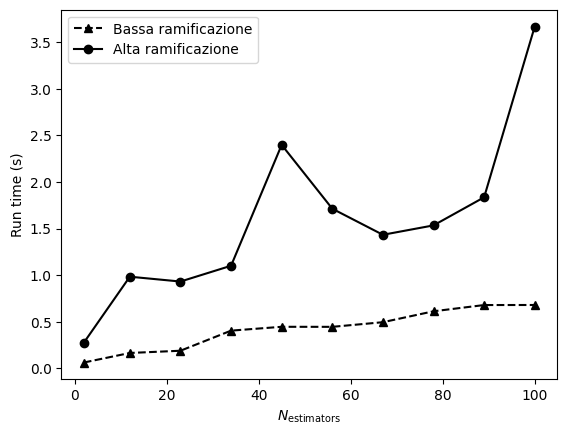

In [14]:
plt.figure()
plt.plot(n_estimator_range,RFC_train_accuracy[1],'--b^',label='Train (bassa ramificazione)')
plt.plot(n_estimator_range,RFC_vali_accuracy[1],'--r^',label='Validation (bassa ramificazione)')
plt.plot(n_estimator_range,RFC_OOB_accuracy[1],'--g^',label='OOB (bassa ramificazione)')

plt.plot(n_estimator_range,RFC_train_accuracy[0],'o-b',label='Train (alta ramificazione)')
plt.plot(n_estimator_range,RFC_vali_accuracy[0],'o-r',label='Validation (alta ramificazione)')
plt.plot(n_estimator_range,RFC_OOB_accuracy[0],'--g^',label='OOB (alta ramificazione)')

plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Accuracy')
lgd=plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(n_estimator_range, run_time[1], '--k^',label='Bassa ramificazione')
plt.plot(n_estimator_range, run_time[0], 'o-k',label='Alta ramificazione')
plt.xlabel('$N_\mathrm{estimators}$')
plt.ylabel('Run time (s)')
plt.legend(loc=2)
plt.show()

**Parte 3**

Allenare un regressore RandomForest (RandomForestRegressor) al task di predire la magnetizzazione media $\hat{M}$ a partire da una configurazione di spin di temperatura nota $T$.

1.   costruire il tensore magnetizzazione media $M$ per ogni elemento dei campioni X_test, X_vali e X_train:


> $M = \frac{1}{N}\sum_i^N S_i$

2.   implementare e allenare il regressore sul training set, usando come loss: MSE
3.   ottimizzare la dimensione della foresta (n_estimators) sul validation set
4.   stimare prestazioni (MAE) sul test set e graficare sul test set lo scatter plot $\hat{M}$ VS $M$ predetta, e l'istogramma di ($M-\hat{M}$)
5.   provare a dare una spiegazione di quanto osservato ...

coeff. of determination R^2 score (train/vali/test):  0.9989867658416313 0.9941923151644152 0.9939824060570062
MAE test:  0.029889831632653015


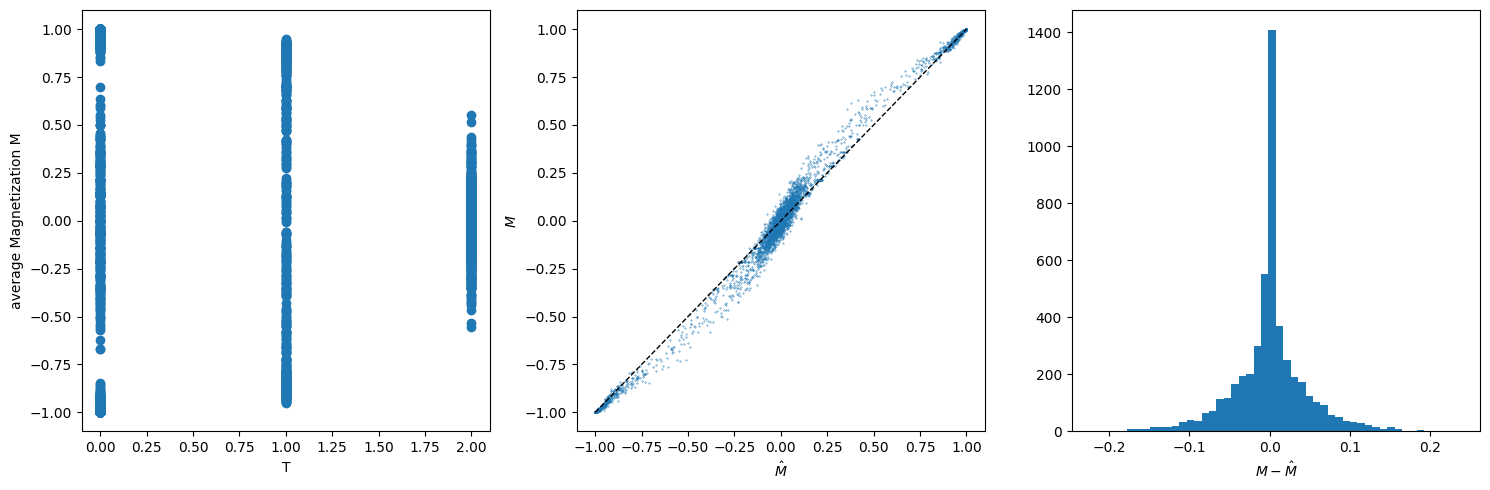

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

M_train = (1/x_train.shape[1])*np.sum(x_train, axis=1)
M_vali = (1/x_vali.shape[1])*np.sum(x_vali, axis=1)
M_test = (1/x_test.shape[1])*np.sum(x_test, axis=1)

myRF_reg = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=2,  # minimum number of sample per leaf
    criterion='squared_error',  # MSE loss (se si vuole usare la MAE: 'absolute_error')
    random_state=0
)

myRF_reg.fit(x_train, M_train)
score = myRF_reg.score(x_train, M_train)
val_score = myRF_reg.score(x_vali, M_vali)
test_score = myRF_reg.score(x_test, M_test)

print('coeff. of determination R^2 score (train/vali/test): ',score,val_score,test_score)

pred = myRF_reg.predict(x_test)
mae = mean_absolute_error(M_test, pred)
print('MAE test: ',mae)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(y_test, M_test)
plt.xlabel('T')
plt.ylabel('average Magnetization M')

plt.subplot(1,3,2)
plt.scatter(pred, M_test, s=0.1)
plt.plot([-1,1],[-1,1], color='black', linewidth=1, linestyle='dashed')
plt.xlabel('$\hat{M}$')
plt.ylabel('$M$')

plt.subplot(1,3,3)
plt.hist(M_test-pred, bins=50)
plt.xlabel('$M-\hat{M}$')
plt.tight_layout()

**Per casa**

* provate a implementare una k-fold (con k=5) validation per l'ottimizzazione dei parametri della RandomForest e verificate se vi sono differenze rispetto all'uso del validation set o di OOB (OOB tende a dare delle stime molto pessimistiche).
    
NOTA: per imparare ad implementare una k-fold validation in scikit-learn guardate questo [tutorial](https://scikit-learn.org/stable/modules/cross_validation.html)


* provare a implementare il punto 2 (classificatore) usando l'algoritmo di gradient boosting xGBoost

In [22]:
from sklearn.model_selection import KFold
# from sklearn.model_selection import StratifiedKFold  quando hai dati sbilanciati, per evitare che un fold predomini
from sklearn.metrics import accuracy_score

rf_clf = RandomForestClassifier(n_estimators=100, min_samples_split=2, random_state=42)
# Imposta K-Fold con k splits
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

# Lista per salvare le accuracy
accuracy_list = []

# Loop sulla K-Fold
for train_index, test_index in kfold.split(data):

    # Allena il modello
    rf_clf.fit(x_train, y_train)

    # Predice sul test set
    y_pred = rf_clf.predict(x_test)

    # Calcola l'accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)

# Stampa i risultati
print(f'Accuracy per fold: {accuracy_list}')
print(f'Media accuracy: {sum(accuracy_list) / len(accuracy_list):.4f}')

Accuracy per fold: [0.9184, 0.9184, 0.9184, 0.9184]
Media accuracy: 0.9184


**Randomized Grid Search con KFold**

In [23]:
from sklearn.model_selection import RandomizedSearchCV  # più veloce di grid search perché non fa tutte le combinazioni ma solo alcune
# contro: potrebbe non trovare la combinazione migliore...
import numpy as np

# Definizione del range degli iperparametri
param_dist = {
    'n_estimators': np.arange(50, 500, 50),  # Da 50 a 500 con step di 50
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20]
}

# Randomized Search con KFold
random_search = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_dist,
                                   n_iter=10, cv=kfold, scoring='accuracy',
                                   n_jobs=-1, verbose=2, random_state=42)

# Allenamento
random_search.fit(data, label)

# Migliori parametri trovati
print("Migliori parametri:", random_search.best_params_)
print("Migliore accuracy media su CV:", random_search.best_score_)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
Migliori parametri: {'n_estimators': 350, 'min_samples_split': 5, 'max_depth': None}
Migliore accuracy media su CV: 0.92048
